In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import stft, istft
import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.__version__

'2.17.1'

In [5]:
import os


audio_files = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train')][:20]
vocals_files = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train')][:20]
# audio_files.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
#                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[:30]])
# vocals_files.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
#                      for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[:30]])


def read_tf_file(file_path):
    file_path = file_path.numpy().decode("utf-8")
    sr, audio = wav.read(file_path)

    return audio.astype(np.float32)

def stft_transform(signal, sample_rate=44100, nperseg=2048, noverlap=2048 // 2):
    frequencies, times, Zxx_l = stft(signal[:, 0], fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hamming')
    frequencies, times, Zxx_r = stft(signal[:, 1], fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hamming')
    return Zxx_l, Zxx_r

def process_audio(audio_file, vocal_file):
    audio = read_tf_file(audio_file)
    Zxx_l, Zxx_r = stft_transform(audio)
    vocals_audio = read_tf_file(vocal_file)
    Zxx_l_v, Zxx_r_v = stft_transform(vocals_audio)
    return tf.abs(Zxx_l), tf.abs(Zxx_r), tf.abs(Zxx_l_v), tf.abs(Zxx_r_v)

def get_ideal_binary_mask(Zxx_vocals, Zxx_mix, threshold=1):
    binary_mask = (np.abs(Zxx_vocals) > threshold * np.abs(Zxx_mix)).astype(float)
    return binary_mask

def get_ideal_mask_tf(stft, stft_vocals):
    mask = get_ideal_binary_mask(stft_vocals, stft)
    return tf.convert_to_tensor(mask, dtype=tf.float32)

def get_window_data_tf(stft, window_size=9):
    transposed_stft = tf.transpose(stft)
    zeros_for_window = np.zeros((window_size // 2, transposed_stft.shape[1]))
    windows = np.zeros((transposed_stft.shape[0], window_size, transposed_stft.shape[1]), dtype=np.float32)
    data_for_windows = np.concatenate([zeros_for_window, transposed_stft, zeros_for_window])

    for i in range(transposed_stft.shape[0]):
        windows[i] = data_for_windows[i:i+window_size]

    return tf.convert_to_tensor(windows, dtype=tf.float32)


def process_with_tf(audio_file, vocal_file):
    stft_left, stft_right, stft_left_vocals, stft_right_vocals = tf.py_function(
        func=process_audio, inp=[audio_file, vocal_file], Tout=(tf.float32, tf.float32, tf.float32, tf.float32)
    )
    mask_left = tf.py_function(
        func=get_ideal_mask_tf, inp=[stft_left, stft_left_vocals], Tout=tf.float32
    )
    mask_right = tf.py_function(
        func=get_ideal_mask_tf, inp=[stft_right, stft_right_vocals], Tout=tf.float32
    )
    left_windows = tf.py_function(
        func=get_window_data_tf, inp=[stft_left], Tout=tf.float32
    )
    right_windows = tf.py_function(
        func=get_window_data_tf, inp=[stft_right], Tout=tf.float32
    )

    left_ds = tf.data.Dataset.from_tensor_slices(left_windows)
    right_ds = tf.data.Dataset.from_tensor_slices(right_windows)
    left_ds_vocals = tf.data.Dataset.from_tensor_slices(tf.transpose(mask_left))
    right_ds_vocals = tf.data.Dataset.from_tensor_slices(tf.transpose(mask_right))

    return tf.data.Dataset.zip(left_ds.concatenate(right_ds), left_ds_vocals.concatenate(right_ds_vocals))

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((audio_files, vocals_files))
dataset = dataset.flat_map(process_with_tf)
# dataset = dataset.map(lambda x, y: (tf.ensure_shape(x, (None, 9, 1025)), tf.ensure_shape(y, (None, 1025, ))) )
# dataset = dataset.batch(32)
# dataset = dataset.map(lambda x, y: (tf.ensure_shape(x, (None, 9, 1025)), tf.ensure_shape(y, (None, 1025))))
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
dataset.map(lambda x, y: (tf.ensure_shape(x, (9, 1025)), tf.ensure_shape(y, (1025, ))) )

<_MapDataset element_spec=(TensorSpec(shape=(9, 1025), dtype=tf.float32, name=None), TensorSpec(shape=(1025,), dtype=tf.float32, name=None))>

In [ ]:
for batch in dataset.take(1):
    x_sample, y_sample = batch
    print("Sample input shape (X):", x_sample.shape)
    print("Sample output shape (Y):", y_sample.shape)

Sample input shape (X): (32, 9, 1025)
Sample output shape (Y): (32, 1025)


In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    concatenate,
    GlobalAveragePooling2D,
    Dense,
    Flatten,
    Reshape,
    ZeroPadding2D
)

In [ ]:
freq_bins = 1025
window_size = 9

def create_model():
    # Input
    inputs = Input(shape=(window_size, freq_bins))
    inputs = Reshape((window_size, freq_bins, 1))(inputs)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = ZeroPadding2D(padding=((0, 1), (0, 1)))(up7)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output
    final_conv = Conv2D(1, (3, 3), activation='relu', padding='same')(conv7)
    pooled = GlobalAveragePooling2D()(final_conv)
    outputs = Dense(freq_bins, activation='sigmoid')(pooled)

    model = Model(inputs=inputs, outputs=outputs, name="vocal_separator")
    return model


def create_model2():
    inputs = tf.keras.Input(shape=(window_size, freq_bins), name="input_audio")
    inputs = tf.keras.layers.Reshape((9, 1025, 1))(inputs)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(freq_bins, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="vocal_separator")
    return model

In [ ]:
model = create_model2()
model.summary()

Model: "vocal_separator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_61CLONE (InputLayer)    │ (None, 9, 1025, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 9, 1025, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 9, 1025, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 512, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1025)                │         263,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,041,345 (65.01 MB)

 Trainable params: 17,041,281 (65.01 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=['accuracy', "mse"]
)
epochs = 5

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(dataset, epochs=epochs)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node EnsureShape defined at (most recent call last):
<stack traces unavailable>
Detected at node EnsureShape defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Error in user-defined function passed to MapDataset:1648 transformation with iterator: Iterator::Root::Prefetch::ParallelMapV2: Shape of tensor args_0 [9,1025] is not compatible with expected shape [?,9,1025].
	 [[{{node EnsureShape}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Error in user-defined function passed to MapDataset:1648 transformation with iterator: Iterator::Root::Prefetch::ParallelMapV2: Shape of tensor args_0 [9,1025] is not compatible with expected shape [?,9,1025].
	 [[{{node EnsureShape}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_843012]

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')

In [ ]:
def binary_crossentropy(y_true, y_pred):
    # Добавляем небольшое значение (epsilon), чтобы избежать log(0)
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    loss = -tf.reduce_mean(
        y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred)
    )
    return loss

for i in dataset.take(1):
  y_true = i[1]
  y_pred = model.predict(i[0])
  loss = binary_crossentropy(y_true, y_pred)
  print(loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
tf.Tensor(0.69314706, shape=(), dtype=float32)


In [8]:
for i in dataset.take(20):
  # print(i[0][0].numpy())

  plt.pcolormesh(i[0][0].numpy().T)

NameError: name 'dataset' is not defined

In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import stft
import os

FRAME_LENGTH = 1024
HOP_LENGTH = 512
SR = 44100
NUM_FRAMES = 25
TARGET_FRAME_INDEX = NUM_FRAMES // 2

def load_audio_with_scipy(file_path, target_sr=SR, frame_length=10 * SR):
    file_path = file_path.numpy().decode("utf-8")
    sr, audio = wavfile.read(file_path)
    if audio.dtype == np.int16:
        audio = audio / 32768.0
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    if sr != target_sr:
        from scipy.signal import resample
        audio = resample(audio, int(len(audio) * target_sr / sr))
    if len(audio) < frame_length:
        audio = np.pad(audio, (0, frame_length - len(audio)), mode='constant')
    else:
        audio = audio[:frame_length]
    return audio

def compute_spectrogram(audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH):
    _, _, Zxx = stft(audio, nperseg=frame_length, noverlap=frame_length - hop_length)
    return np.abs(Zxx)

# Создание бинарной маски
def create_binary_mask(vocal_spec, mix_spec, threshold=1):
    return (vocal_spec > threshold * mix_spec).astype(np.int32)

def get_window_from_spectrogram(spectrogram, start_idx, num_frames=NUM_FRAMES):
    num_freq_bins, num_time_frames = spectrogram.shape
    window = np.zeros((num_freq_bins, num_frames))

    start = max(0, start_idx)
    end = min(start_idx + num_frames, num_time_frames)

    insert_start = max(0, -start_idx)
    insert_end = insert_start + (end - start)

    window[:, insert_start:insert_end] = spectrogram[:, start:end]

    return window

def preprocess_pair_with_scipy(mix_path, vocal_path):
    mix_audio = load_audio_with_scipy(mix_path)
    vocal_audio = load_audio_with_scipy(vocal_path)

    mix_spec = compute_spectrogram(mix_audio)
    vocal_spec = compute_spectrogram(vocal_audio)
    mask = create_binary_mask(vocal_spec, mix_spec)

    X, y = [], []
    for i in range(-(NUM_FRAMES // 2), mix_spec.shape[1] - (NUM_FRAMES // 2)):
        window = get_window_from_spectrogram(mix_spec, i, NUM_FRAMES)
        target_frame = mask[:, max(0, min(i + TARGET_FRAME_INDEX, mask.shape[1] - 1))]
        X.append(window)
        y.append(target_frame)
    return np.array(X), np.array(y)

def tf_preprocess(mix_path, vocal_path):
    X, y = tf.py_function(
        func=preprocess_pair_with_scipy,
        inp=[mix_path, vocal_path],
        Tout=[tf.float32, tf.float32],
    )
    X.set_shape([None, 513, NUM_FRAMES])
    y.set_shape([None, 513])
    return X, y


mix_files = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train')]
vocal_files = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train')]
mix_files.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[:30]])
vocal_files.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[:30]])

mix_files_test = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][:25]
vocal_files_test = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][:25]
mix_files_test.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[30:40]])
vocal_files_test.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[30:40]])

mix_files_validation = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][25:]
vocal_files_validation = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][25:]
mix_files_validation.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[40:]])
vocal_files_validation.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[40:]])

file_dataset = tf.data.Dataset.from_tensor_slices((mix_files, vocal_files))
file_dataset_test = tf.data.Dataset.from_tensor_slices((mix_files_test, vocal_files_test))
file_dataset_validation = tf.data.Dataset.from_tensor_slices((mix_files_validation, vocal_files_validation))

train_dataset = file_dataset.map(tf_preprocess)
test_dataset = file_dataset_test.map(tf_preprocess)
valid_dataset = file_dataset_validation.map(tf_preprocess)

BATCH_SIZE = 32
epochs=20
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset = valid_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

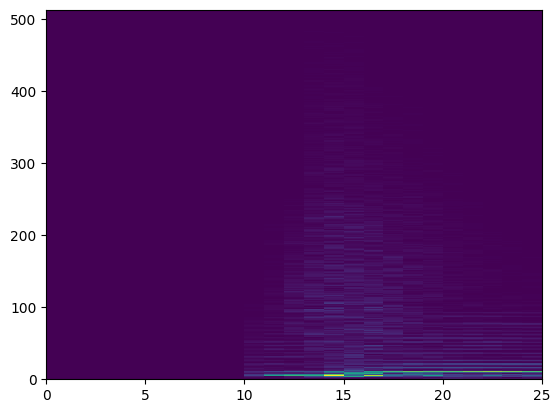

In [33]:
for i in train_dataset.take(5):

  plt.pcolormesh(i[0][20].numpy())

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
    Conv2DTranspose,
    concatenate,
    GlobalAveragePooling2D,
    Dense,
    Flatten,
    Reshape,
    ZeroPadding2D,
    Dropout,
    BatchNormalization,
    Activation,
)

freq_bins = 513


def unet(input_shape=(freq_bins, NUM_FRAMES, 1)):

    # Input
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (5, 5), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (5, 5), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    # Bottleneck
    conv4 = Conv2D(512, (5, 5), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, (5, 5), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)

    # Decoder
    up5 = Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same")(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, (5, 5), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (5, 5), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)

    up6 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same")(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, (5, 5), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (5, 5), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same")(conv6)
    up7 = ZeroPadding2D(padding=((0, 1), (0, 1)))(up7)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, (5, 5), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (5, 5), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation("relu")(conv7)

    # Output
    final_conv = Conv2D(1, (5, 5), activation='relu', padding='same')(conv7)
    final_conv = BatchNormalization()(final_conv)
    final_conv = Activation("relu")(final_conv)
    # pooled = GlobalAveragePooling2D()(final_conv)
    pooled = Flatten()(final_conv)
    pooled = Dense(256, activation="relu")(pooled)
    pooled = Dropout(0.2)(pooled)
    outputs = Dense(freq_bins, activation='sigmoid')(pooled)

    model = Model(inputs=inputs, outputs=outputs, name="vocal_separator")
    return model

In [8]:
def dataset_length(dataset):
    return sum(1 for _ in dataset)

train_size = dataset_length(train_dataset)
val_size = dataset_length(val_dataset)

steps_per_epoch = train_size
validation_steps = val_size

<ipython-input-1-c163675cfd60>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


In [5]:
validation_steps

943

In [6]:
steps_per_epoch

3505

In [3]:
model = unet()
model.summary()

Model: "vocal_separator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 513, 25, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 513, 25, 64)    │          1,664 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 513, 25, 64)    │        102,464 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 513, 25, 64)    │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 513, 25, 64)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 12, 64)    │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 12, 64)    │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 12, 128)   │        204,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 12, 128)   │        409,728 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 12, 128)   │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 12, 128)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 6, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 6, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 6, 256)    │        819,456 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 6, 256)    │      1,638,656 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 6, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 6, 256)    │              0 │ batch_normalization_2… │
├──────────────────────

 Total params: 27,186,246 (103.71 MB)

 Trainable params: 27,182,404 (103.69 MB)

 Non-trainable params: 3,842 (15.01 KB)

In [6]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy']
)
epochs=20

In [5]:
with tf.device('/device:GPU:0'):
  history = model.fit(
    train_dataset.repeat(epochs),
    validation_data=val_dataset.repeat(epochs),
    epochs=epochs,
    steps_per_epoch=3505,
    validation_steps=943,
    verbose=1
  )

Epoch 1/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.0177 - loss: 1.2460

<ipython-input-1-c163675cfd60>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


3505/3505 ━━━━━━━━━━━━━━━━━━━━ 975s 263ms/step - accuracy: 0.0177 - loss: 1.2460 - val_accuracy: 3.9767e-04 - val_loss: 1.2686
Epoch 2/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 905s 258ms/step - accuracy: 0.0016 - loss: 1.2298 - val_accuracy: 3.9767e-04 - val_loss: 1.3335
Epoch 3/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 905s 258ms/step - accuracy: 0.0017 - loss: 1.2254 - val_accuracy: 3.9767e-04 - val_loss: 1.2422
Epoch 4/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 906s 258ms/step - accuracy: 7.4679e-04 - loss: 1.2215 - val_accuracy: 3.9767e-04 - val_loss: 1.2575
Epoch 5/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 906s 258ms/step - accuracy: 7.2502e-04 - loss: 1.2303 - val_accuracy: 3.9767e-04 - val_loss: 1.2610
Epoch 6/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 906s 258ms/step - accuracy: 0.0011 - loss: 1.2203 - val_accuracy: 3.9767e-04 - val_loss: 1.2398
Epoch 7/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 906s 258ms/step - accuracy: 0.0045 - loss: 1.1978 - val_accuracy: 3.9767e-04 - val_loss: 1.2437
Epoch 8/20
3505/3505 ━━━━━━━━━━━━━━━━

In [7]:
model.save("drive/MyDrive/saved_models/unet_model2.keras")

In [9]:
model.evaluate(test_dataset)

    618/Unknown 47s 72ms/step - accuracy: 0.0031 - loss: 1.3432

<ipython-input-1-c163675cfd60>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


943/943 ━━━━━━━━━━━━━━━━━━━━ 69s 71ms/step - accuracy: 0.0027 - loss: 1.3126


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[1.2277427911758423, 0.0016238070093095303]

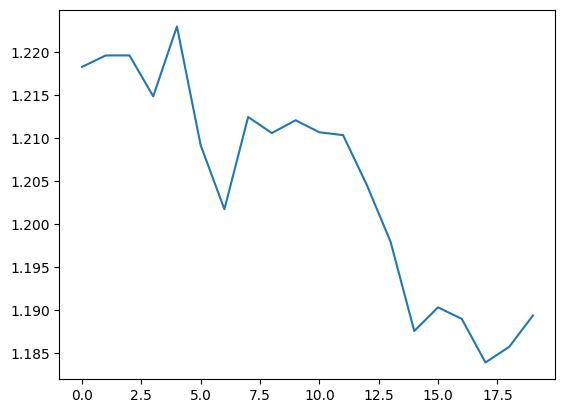

In [11]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.show()

In [12]:
history.history['loss']

[1.2183226346969604,
 1.219651460647583,
 1.2196564674377441,
 1.2148933410644531,
 1.2230232954025269,
 1.2092039585113525,
 1.2017627954483032,
 1.2124897241592407,
 1.2106255292892456,
 1.2121115922927856,
 1.2107162475585938,
 1.2103840112686157,
 1.204590916633606,
 1.1979974508285522,
 1.1875931024551392,
 1.1903456449508667,
 1.1890168190002441,
 1.1839356422424316,
 1.185752034187317,
 1.1893994808197021]

In [24]:
history.history['val_loss']

[1.2686485052108765,
 1.3334850072860718,
 1.2422432899475098,
 1.257532000541687,
 1.2610441446304321,
 1.2398254871368408,
 1.243748664855957,
 1.263462781906128,
 1.269717812538147,
 1.2782102823257446,
 1.2879589796066284,
 1.285735011100769,
 1.31197190284729,
 1.7820649147033691,
 6.797653675079346,
 1.256176233291626,
 1.2505818605422974,
 1.263431191444397,
 1.2517234086990356,
 1.3294405937194824]

In [23]:
for i in test_dataset.skip(52).take(5):
  y_true = i[1]
  y_pred = model.predict(i[0])

  print(tf.keras.losses.BinaryCrossentropy()(y_true, y_pred))
  print(np.sum(y_pred > 0.5))
  print(np.sum(y_true))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
tf.Tensor(0.17491367, shape=(), dtype=float32)
1959
0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
tf.Tensor(0.2311837, shape=(), dtype=float32)
2140
301.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
tf.Tensor(1.0992136, shape=(), dtype=float32)
1056
4789.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
tf.Tensor(1.0944068, shape=(), dtype=float32)
1056
4774.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
tf.Tensor(1.0653462, shape=(), dtype=float32)
1056
4591.0


In [31]:
from tensorflow.keras.layers import Permute, LSTM, Dropout, Dense, TimeDistributed, Lambda, Bidirectional, Attention, Add


def rnn(input_shape=(freq_bins, NUM_FRAMES)):
    inputs = Input(shape=input_shape)

    x = Permute((2, 1))(inputs)

    x = Bidirectional(LSTM(256, return_sequences=True, activation='relu'))(x)
    x = Dropout(0.3)(x)

    scores = Attention()([x, x])
    x = Add()([x, scores])

    x = LSTM(256, return_sequences=True, activation='sigmoid')(x)
    x = Dropout(0.3)(x)

    x = TimeDistributed(Dense(freq_bins, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(x)

    outputs = Lambda(lambda x: x[:, TARGET_FRAME_INDEX, :])(x)

    model = Model(inputs, outputs)
    return model

In [33]:
model2 = rnn()
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 513, 25)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_2 (Permute)       │ (None, 25, 513)        │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 25, 512)        │      1,576,960 │ permute_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 25, 512)        │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 25, 512)        │              0 │ dropout_8[0][0],       │
│                           │                        │                │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 25, 512)        │              0 │ dropout_8[0][0],       │
│                           │                        │                │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 25, 256)        │        787,456 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 25, 256)        │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 25, 513)        │        131,841 │ dropout_9[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 513)            │              0 │ time_distributed_2[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,496,257 (9.52 MB)

 Trainable params: 2,496,257 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=["accuracy", 'binary_crossentropy']
)

# Callbacks
checkpoint = ModelCheckpoint("drive/MyDrive/saved_models/rnn.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)

epochs = 30

In [36]:
history_rnn = model2.fit(
    train_dataset.repeat(epochs),
    validation_data=val_dataset.repeat(epochs),
    epochs=epochs,
    steps_per_epoch=3505,
    validation_steps=943,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/30
3503/3505 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0413 - binary_crossentropy: 0.4023 - loss: 2.2269

<ipython-input-1-c163675cfd60>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


3505/3505 ━━━━━━━━━━━━━━━━━━━━ 142s 37ms/step - accuracy: 0.0413 - binary_crossentropy: 0.4022 - loss: 2.2263 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3605 - val_loss: 1.3541
Epoch 2/30
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 122s 35ms/step - accuracy: 0.0372 - binary_crossentropy: 0.3012 - loss: 1.2835 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3601 - val_loss: 1.3444
Epoch 3/30
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 117s 33ms/step - accuracy: 0.0359 - binary_crossentropy: 0.2980 - loss: 1.2752 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3599 - val_loss: 1.3395
Epoch 4/30
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 108s 31ms/step - accuracy: 0.0353 - binary_crossentropy: 0.2961 - loss: 1.2696 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3595 - val_loss: 1.3330
Epoch 5/30
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 104s 30ms/step - accuracy: 0.0346 - binary_crossentropy: 0.2943 - loss: 1.2643 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3592 - val_loss: 1.3285
Epoch 

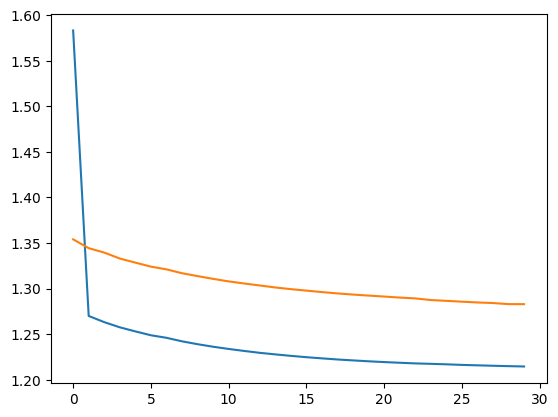

In [39]:
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])

In [40]:
epochs = 10
history_rnn2 = model2.fit(
    train_dataset.repeat(epochs),
    validation_data=val_dataset.repeat(epochs),
    epochs=epochs,
    steps_per_epoch=3505,
    validation_steps=943,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
3503/3505 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0175 - binary_crossentropy: 0.2783 - loss: 1.2223

<ipython-input-1-c163675cfd60>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


3505/3505 ━━━━━━━━━━━━━━━━━━━━ 129s 37ms/step - accuracy: 0.0175 - binary_crossentropy: 0.2783 - loss: 1.2222 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3563 - val_loss: 1.2819
Epoch 2/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 122s 35ms/step - accuracy: 0.0166 - binary_crossentropy: 0.2780 - loss: 1.2218 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3571 - val_loss: 1.2819
Epoch 3/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 118s 34ms/step - accuracy: 0.0135 - binary_crossentropy: 0.2779 - loss: 1.2216 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3596 - val_loss: 1.2848
Epoch 4/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 109s 31ms/step - accuracy: 0.0061 - binary_crossentropy: 0.2780 - loss: 1.2210 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3538 - val_loss: 1.2790
Epoch 5/10
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 105s 30ms/step - accuracy: 0.0014 - binary_crossentropy: 0.2785 - loss: 1.2213 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3526 - val_loss: 1.2782
Epoch 

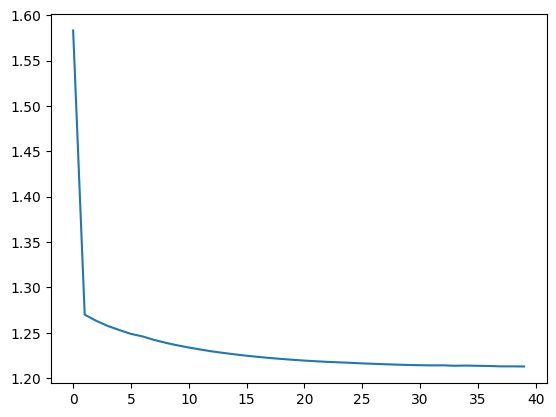

In [47]:
plt.plot(np.concatenate([history_rnn.history['loss'], history_rnn2.history['loss']]))
# plt.plot(history_rnn2.history['val_loss'])

In [48]:
np.concatenate([history_rnn.history['loss'], history_rnn2.history['loss']])

array([1.58324003, 1.2699945 , 1.26319683, 1.2575264 , 1.25303853,
       1.24880731, 1.24602628, 1.24215782, 1.23901272, 1.23622215,
       1.23378837, 1.23158598, 1.22953248, 1.22781467, 1.22620535,
       1.2247355 , 1.22345901, 1.22223341, 1.22121155, 1.2202388 ,
       1.21938837, 1.21864021, 1.21793091, 1.21745563, 1.21691036,
       1.21628761, 1.21581101, 1.21534014, 1.21491504, 1.21455073,
       1.21427763, 1.21407449, 1.2141552 , 1.21367562, 1.21390605,
       1.21361589, 1.2134161 , 1.2129997 , 1.21300495, 1.2128818 ])

In [74]:
def rnn_v2(input_shape=(freq_bins, NUM_FRAMES)):
    inputs = Input(shape=input_shape)

    x = Permute((2, 1))(inputs)

    x = Bidirectional(LSTM(256, return_sequences=True, activation='sigmoid'))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(256, return_sequences=True, activation='sigmoid'))(x)
    x = Dropout(0.3)(x)

    attention = Attention()([x, x])
    x = Add()([x, attention])

    x = TimeDistributed(Dense(freq_bins, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(x)

    outputs = Lambda(lambda x: x[:, TARGET_FRAME_INDEX, :])(x)

    model = Model(inputs, outputs)
    return model

In [75]:
model3 = rnn_v2()
model3.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 513, 25)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_7 (Permute)       │ (None, 25, 513)        │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_19          │ (None, 25, 512)        │      1,576,960 │ permute_7[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 25, 512)        │              0 │ bidirectional_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_20          │ (None, 25, 512)        │      1,574,912 │ dropout_32[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 25, 512)        │              0 │ bidirectional_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_7 (Attention)   │ (None, 25, 512)        │              0 │ dropout_33[0][0],      │
│                           │                        │                │ dropout_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 25, 512)        │              0 │ dropout_33[0][0],      │
│                           │                        │                │ attention_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_11       │ (None, 25, 513)        │        263,169 │ add_8[0][0]            │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_11 (Lambda)        │ (None, 513)            │              0 │ time_distributed_11[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,415,041 (13.03 MB)

 Trainable params: 3,415,041 (13.03 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=bce_dice_loss,
    metrics=["accuracy", 'binary_crossentropy']
)

# Callbacks
checkpoint = ModelCheckpoint("drive/MyDrive/saved_models/rnn_v2_2.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)

epochs = 20

In [77]:
history_rnn_v2 = model3.fit(
    train_dataset.repeat(epochs),
    validation_data=val_dataset.repeat(epochs),
    epochs=epochs,
    steps_per_epoch=3505,
    validation_steps=943,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
3503/3505 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0281 - binary_crossentropy: 0.2647 - loss: 1.4112

<ipython-input-1-c163675cfd60>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


3505/3505 ━━━━━━━━━━━━━━━━━━━━ 141s 38ms/step - accuracy: 0.0281 - binary_crossentropy: 0.2647 - loss: 1.4111 - val_accuracy: 2.9825e-04 - val_binary_crossentropy: 0.3670 - val_loss: 1.3096
Epoch 2/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 123s 35ms/step - accuracy: 0.0282 - binary_crossentropy: 0.2569 - loss: 1.2087 - val_accuracy: 2.9825e-04 - val_binary_crossentropy: 0.3667 - val_loss: 1.2987
Epoch 3/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 118s 34ms/step - accuracy: 0.0271 - binary_crossentropy: 0.2534 - loss: 1.1991 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3650 - val_loss: 1.2952
Epoch 4/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 109s 31ms/step - accuracy: 0.0126 - binary_crossentropy: 0.2604 - loss: 1.2072 - val_accuracy: 6.6278e-05 - val_binary_crossentropy: 0.3675 - val_loss: 1.2906
Epoch 5/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 105s 30ms/step - accuracy: 0.0104 - binary_crossentropy: 0.2511 - loss: 1.1963 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3668 - val_loss: 1.2872
Epoch 

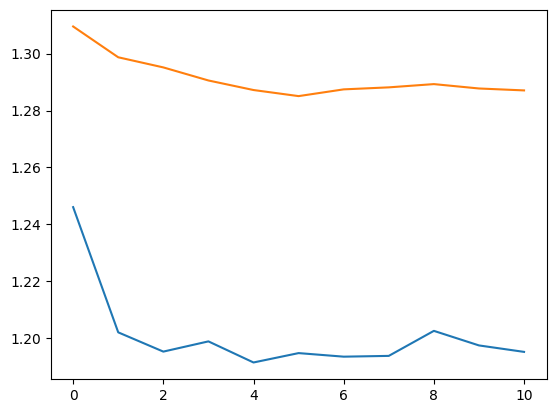

In [78]:
plt.plot(history_rnn_v2.history['loss'])
plt.plot(history_rnn_v2.history['val_loss'])

In [85]:
def rnn_v3(input_shape=(freq_bins, NUM_FRAMES, 1)):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 1))(x)

    x = Reshape((x.shape[2], -1))(x)

    x = Bidirectional(LSTM(128, return_sequences=True, activation='sigmoid'))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(128, return_sequences=True, activation='sigmoid'))(x)
    x = Dropout(0.3)(x)

    attention = Attention()([x, x])
    x = Add()([x, attention])

    x = TimeDistributed(Dense(freq_bins, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(x)

    outputs = Lambda(lambda x: x[:, TARGET_FRAME_INDEX, :])(x)

    model = Model(inputs, outputs)
    return model

In [86]:
model4 = rnn_v3()
model4.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 513, 25, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 513, 25, 32)    │            320 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 513, 25, 32)    │            128 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 256, 25, 32)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 25, 8192)       │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_21          │ (None, 25, 256)        │      8,520,704 │ reshape_5[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 25, 256)        │              0 │ bidirectional_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_22          │ (None, 25, 256)        │        394,240 │ dropout_34[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 25, 256)        │              0 │ bidirectional_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_8 (Attention)   │ (None, 25, 256)        │              0 │ dropout_35[0][0],      │
│                           │                        │                │ dropout_35[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 25, 256)        │              0 │ dropout_35[0][0],      │
│                           │                        │                │ attention_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_12       │ (None, 25, 513)        │        131,841 │ add_9[0][0]            │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_12 (Lambda)        │ (None, 513)            │              0 │ time_distributed_12[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,047,233 (34.51 MB)

 Trainable params: 9,047,169 (34.51 MB)

 Non-trainable params: 64 (256.00 B)

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=["accuracy", 'binary_crossentropy']
)

# Callbacks
checkpoint = ModelCheckpoint("drive/MyDrive/saved_models/cnn_rnn_true.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)

epochs = 20

In [90]:
history_cnn_rnn = model4.fit(
    train_dataset.repeat(epochs),
    validation_data=val_dataset.repeat(epochs),
    epochs=epochs,
    steps_per_epoch=3505,
    validation_steps=943,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0389 - binary_crossentropy: 0.3474 - loss: 2.2086

<ipython-input-1-c163675cfd60>:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(file_path)


3505/3505 ━━━━━━━━━━━━━━━━━━━━ 195s 51ms/step - accuracy: 0.0389 - binary_crossentropy: 0.3474 - loss: 2.2085 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3672 - val_loss: 1.3239
Epoch 2/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 175s 50ms/step - accuracy: 0.0349 - binary_crossentropy: 0.2858 - loss: 1.2546 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3763 - val_loss: 1.3233
Epoch 3/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 174s 50ms/step - accuracy: 0.0285 - binary_crossentropy: 0.2818 - loss: 1.2448 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3774 - val_loss: 1.3227
Epoch 4/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 172s 49ms/step - accuracy: 0.0273 - binary_crossentropy: 0.2811 - loss: 1.2428 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3782 - val_loss: 1.3202
Epoch 5/20
3505/3505 ━━━━━━━━━━━━━━━━━━━━ 167s 48ms/step - accuracy: 0.0275 - binary_crossentropy: 0.2809 - loss: 1.2411 - val_accuracy: 3.9767e-04 - val_binary_crossentropy: 0.3796 - val_loss: 1.3203
Epoch 

KeyboardInterrupt: 